<a href="https://colab.research.google.com/github/Gasijiyo/FirstStep_ML/blob/master/ml11_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Learning (앙상블 학습 방법)

* 앙상블(ensemble): 머신 러닝에서 사용되는 일련의 모델(알고리즘)들.
    * 서로 다른 모델 여러개를 학습시키는 방법.
    * 한 가지 모델을 서로 다른 훈련 셋에서 학습시키는 방법.
* 앙상블 학습 방법:
    * 투표(voting) 방식: 여러 모델을 학습시켜서 각각의 예측값들을 투표(다수결) 또는 평균값으로 예측하는 방식
    * __Bagging(Bootstrap Aggregating)__: 중복을 허용해서 샘플링한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측(다수결, 평균)하는 방법.
    * Pasting: 중복을 허용하지 않고 샘플링한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측하는 방법.
* __Random Forest__: Bagging을 사용한 Decision Tree들의 Ensemble 학습 방법.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC # SVM (Support Vector Machine)을 사용한 분류 알고리즘.
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier    

# Datasets 준비

2개의 특성(x1, x2)과 2개 클래스(0, 1)를 갖는 가상의 데이터 셋 - 분류(classification) 문제

In [ ]:
# X: 특성 행렬(2차원 배열), y: 레이블 배열
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

In [ ]:
X.shape, y.shape

((500, 2), (500,))

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([250, 250]))

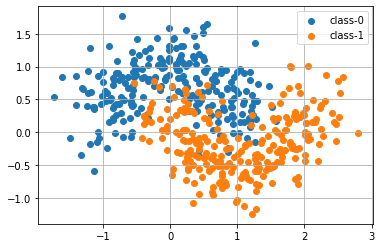

In [ ]:
# 데이터 셋 시각화
plt.scatter(X[y == 0,0], X[y == 0, 1], label='class-0')
plt.scatter(X[y == 1,0], X[y == 1,1], label='class-1')

plt.legend()
plt.grid()
plt.show()

In [ ]:
# 훈련 / 테스트 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

# 머신 러닝 모델 비교

* 여러개의 머신 러닝 모델들을 훈련 셋(X_train, y_train)으로 학습시킴.
    * KNN, Logistic Regression, SGD, Decision Tree, SVM
* 훈련된 각 모델의 교차 검증 점수(정확도)를 계산, 평가

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)
log_reg = LogisticRegression(random_state=42, n_jobs=-1)
sgd = SGDClassifier(loss='log', random_state=42, n_jobs=-1) 
# log 인 이유: 분류 확률 계산할 필요 있음.
tree = DecisionTreeClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)

In [ ]:
classifiers = [knn, log_reg, sgd, tree, svm]
for clf in classifiers:
    cv = cross_validate(estimator=clf, X=X_train, y=y_train, cv=5, n_jobs=-1)
    score = np.mean(cv['test_score'])
    print(clf.__class__.__name__, 'acc.:', score)

KNeighborsClassifier acc.: 0.9099999999999999
LogisticRegression acc.: 0.845
SGDClassifier acc.: 0.8375
DecisionTreeClassifier acc.: 0.8925000000000001
SVC acc.: 0.9225


# Voting Ensemble

In [ ]:
voting = VotingClassifier(estimators=[('knn', knn),
                                      ('log_reg', log_reg),
                                      ('sgd', sgd),
                                      ('tree', tree),
                                      ('svm', svm)],
                          voting='soft', n_jobs=-1)
# VotingClassifier 파라미터
#> estimators: 투표 방식 앙상블을 만들기 위한 ML 모델들의 리스트
#> voting: 투표 방식
#>> hard: 모든 앙상블들이 동일하게 1표씩 행사, 예측 확률을 계산할 필요 없음
#>> soft: 각 모델의 예측값에 각 모델에서 예측된 예측확률을 가중치로 곱한 값을 사용해서 예측.
# 일반적으로 soft voting 이 hard voting 보다 성능이 더 좋다고 알려져 있음.

In [ ]:
cv = cross_validate(estimator=voting, X=X_train, y=y_train, cv=5, n_jobs=-1)

In [ ]:
np.mean(cv['test_score'])

0.9075000000000001

# Bagging(Bootstrap Aggregating) Ensemble

In [ ]:
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                            n_estimators=50,
                            max_samples=100,
                            bootstrap=True,
                            oob_score=True,
                            n_jobs=-1,
                            random_state=42)

BaggingClassifier 파라미터:

* base_estimator: 기본 예측기. 머신 러닝 알고리즘(모델) 객체.
* n_estimator: 앙상블을 만드는 예측기(머신 러닝 모델)의 개수.
* max_samples: 훈련 셋의 부분 집합이 가질 수 있는 최대 샘플 개수(정수) 또는 비율. (0 ~ 1.0)
* bootstrap: True(중복 허용 샘플링), False(중복 허용하지 않고 샘플링 - pasting).
* oob_score: True(OOB 샘플들로 평가 점수 계산), False(OOB 샘플들로 평가 점수를 계산하지 않음). 기본값은 False.
    * OOB(Out of Bagging) 샘플: 중복 허용해서 샘플링하는 (부분집합을 만드는)동안에 한번도 샘플링 되지 못하고 남아 있는 훈련 셋의 샘플들. 앙상블 학습 동안에 한번도 학습에 사용되지 못한 샘플들.
    * OOB 샘플은 검증 셋(validation set)의 역할을 할 수 있음.
    * 테스트 셋에서의 점수를 예상할 수 있음.

In [ ]:
bagging.fit(X_train, y_train)   # bagging ensemble 모델 훈련

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=50, n_jobs=-1, oob_score=True,
                  random_state=42)

In [ ]:
bagging.oob_score_  # OOB샘플들로 계산한 정확도 --> 보통 테스트 점수와 비슷.

0.91

In [ ]:
bagging.score(X_test, y_test)

0.9

# Random Forest

Decision Tree들을 사용하는 Bagging ensemble 학습방법.

In [ ]:
# Random Forest 분류기 객체 생성
forest = RandomForestClassifier(n_estimators=50, max_samples=100, oob_score=True, 
                                n_jobs=-1, random_state=42)

In [ ]:
# 모델 훈련
forest.fit(X_train, y_train)

RandomForestClassifier(max_samples=100, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=42)

In [ ]:
# OOB 점수
forest.oob_score_

0.9125